# 가치평가
몬테카를로 시뮬레이션의 가장 중요한 응용은 옵션, 파생상품, 하이브리드 상품 등의 조건부 청구권의 가치를 펴가하는 것이다. 쉽게 말하자면 조건부 청구권의 가치는 위험 중립 또는 마틴게일 측도 하에서 기대 페이오프를 할인한 것과 같다. 위험 중립 측도는 주식, 지수 등의 모든 위험 요인이 무위험 단기 이자율에 따라 증가하도록 하는 확률 측도이다. 자산 ㅏ격결정 기본 정리에 따르면 무위험 차익 거래의 부존재와 위험 중립 측도의 존재는 서로 동치이다.

## 유러피안 옵션

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
def gen_sn(M, I, anti_paths=True, mo_match=True):
    if anti_paths is True:
        sn = npr.standard_normal((M+1, int(I/2)))
        sn = np.concatenate((sn,-sn), axis=1)
    else:
        sn = npr.standard_normal((M+1, I))
    if mo_match is True:
        sn = (sn - sn.mean()) / sn.std()
    return sn

In [30]:
s0 = 100 #초기값
r = 0.05 # 고정 단기 이자율
sigma = 0.25 # 고정 변동성
T = 1.0 #연단위
I = 50000 # 난수 개수
def gbm_mcs_stat(K):
    #유러피안 콜 옵션을 bsm 모형과 만기 주가의 몬테카를로 시뮬레이션을 사용하여 가치평가
    sn = gen_sn(1,I) # 만기 시의 주가를 시뮬레이션
    sT = s0 *np.exp((r-0.5*sigma**2) *T
                   + sigma*np.sqrt(T)*sn[1])
    hT = np.maximum(sT-K, 0) # 만기 시 페이오프를 계산
    # 몬테카를로 추정치
    C0 = np.exp(-r*T) * 1/I*np.sum(hT)
    return C0

In [31]:
gbm_mcs_stat(K=105)

10.069706554158023

In [41]:
# 동적인 시뮬레이션 방식으로 풋옵션의 가치
M = 50
def gbm_mcs_dyna(K, option='call'):
    dt = T/M
    S = np.zeros((M+1, I))
    S[0] = s0
    sn = gen_sn(M, I)
    for t in range(1, M+1):
        S[t] = S[t -1]*np.exp((r - 0.5*sigma**2) *dt
                             + sigma*np.sqrt(dt)*sn[t])
    if option == 'call':
        hT = np.maximum(S[-1]-K, 0)
    else:
        hT = np.maximum(K- S[-1], 0) # 옵션 유형에 따른 페이오프 계산
     #몬테카를로 추정
    C0 = np.exp(-r*T) *1/I *np.sum(hT)
     
    return C0

In [42]:
gbm_mcs_dyna(K=110, option='call')

7.992046973688549

In [43]:
gbm_mcs_dyna(K=110, option='put')

12.655955596807248

이렇게 시뮬레이션 방식으로 계산한 값이 bsm 공식과 얼마나 일치할까?

In [46]:
from bsm_functions import bsm_call_value

In [49]:
stat_res=[]
dyna_res=[]
anal_res=[]
k_list = np.arange(80,120.1,5.)
np.random.seed(200000)
for K in k_list:
    stat_res.append(gbm_mcs_stat(K))
    dyna_res.append(gbm_mcs_dyna(K))
    anal_res.append(bsm_call_value(s0,K,T,r,sigma))
stat_res = np.array(stat_res)
dyna_res = np.array(dyna_res)
anal_res = np.array(anal_res)

C:\Users\tohot\Anaconda3\envs\fba_1\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


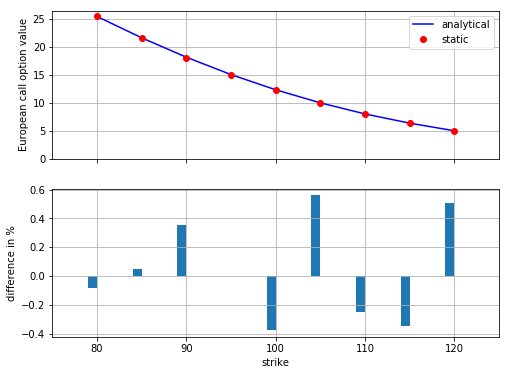

In [54]:
# 정적 시뮬레이션 방식과의 비교
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,6))
ax1.plot(k_list, anal_res, 'b', label='analytical')
ax1.plot(k_list, stat_res, 'ro', label='static')
ax1.set_ylabel('European call option value')
ax1.grid(True)
ax1.legend(loc=0)
ax1.set_ylim(ymin=0)
wi = 1.0
ax2.bar(k_list - wi / 2, (anal_res - stat_res) / anal_res*100, wi)
ax2.set_xlabel('strike')
ax2.set_ylabel('difference in %')
ax2.set_xlim(left=75, right=125)
ax2.grid(True)

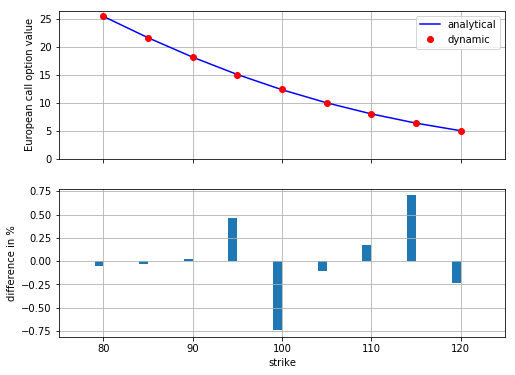

In [55]:
# 동적 시뮬레이션 방식과의 비교
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,6))
ax1.plot(k_list, anal_res, 'b', label='analytical')
ax1.plot(k_list, dyna_res, 'ro', label='dynamic')
ax1.set_ylabel('European call option value')
ax1.grid(True)
ax1.legend(loc=0)
ax1.set_ylim(ymin=0)
wi = 1.0
ax2.bar(k_list - wi / 2, (anal_res - dyna_res) / anal_res*100, wi)
ax2.set_xlabel('strike')
ax2.set_ylabel('difference in %')
ax2.set_xlim(left=75, right=125)
ax2.grid(True)

## 아메리칸 옵션
최적 정지 문제를 풀어야 한다. 이 문제는 시뮬레이션 상에서 이산 시간 그리드를 사용하여 풀 수 있다.  
이렇게 하면 아메리칸 옵션이 아니라 트정 그리드 점에서 행사가 가능한 버뮤다 옵션 문제를 푸는 셈이지만 시간 그리드의 간격을 좁히면 아메리카 옵션으로 수렵한다.


In [56]:
def gbm_mcs_amer(K, option='call'):
    dt = T/M
    df = np.exp(-r*dt)
    S = np.zeros((M+1, I))
    S[0] = s0
    sn = gen_sn(M, I)
    for t in range(1, M+1):
        S[t] = S[t -1]*np.exp((r - 0.5*sigma**2) *dt
                             + sigma*np.sqrt(dt)*sn[t])
   
    if option == 'call':
        h = np.maximum(S-K, 0)
    else:
        h = np.maximum(K- S, 0) # 옵션 유형에 따른 페이오프 계산
    
    #LSM 알고리즘
    V = np.copy(h)
    for t in range(M-1, 0, -1):
        reg = np.polyfit(S[t], V[t+1]*df, 7)
        C = np.polyval(reg, S[t])
        V[t] = np.where(C > h[t], V[t+1]*df, h[t])
    #몬테카를로 추정
    C0 = df *1/I *np.sum(V[1])
    return C0

In [57]:
gbm_mcs_amer(110., option='call')

7.778933279449315

In [58]:
gbm_mcs_amer(110., option='put')

13.614023206242445

조기 행사 프리미엄 추정

In [59]:
euro_res=[]
amer_res=[]
k_list = np.arange(80.,120.1, 5.)
for K in k_list:
    euro_res.append(gbm_mcs_dyna(K, 'put'))
    amer_res.append(gbm_mcs_amer(K, 'put'))
euro_res = np.array(euro_res)
amer_res = np.array(amer_res)

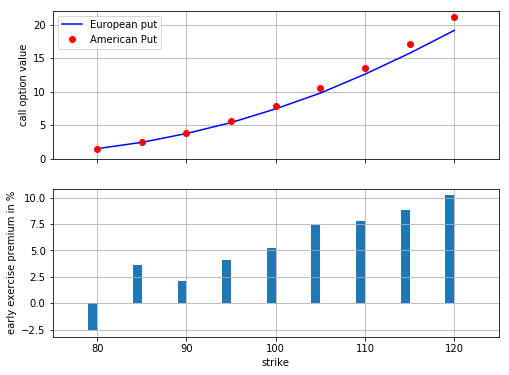

In [60]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,6))
ax1.plot(k_list, euro_res, 'b', label='European put')
ax1.plot(k_list, amer_res, 'ro', label='American Put')
ax1.set_ylabel('call option value')
ax1.grid(True)
ax1.legend(loc=0)
ax1.set_ylim(ymin=0)
wi = 1.0
ax2.bar(k_list - wi / 2, (amer_res - euro_res) / euro_res*100, wi)
ax2.set_xlabel('strike')
ax2.set_ylabel('early exercise premium in %')
ax2.set_xlim(left=75, right=125)
ax2.grid(True)